In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta
import random
from sklearn.preprocessing import StandardScaler
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
pd.set_option('display.max_columns', None)
os.chdir('C:\\Users\\baner\\OneDrive\\Desktop\\Guided Financial Management')

In [3]:
ds = pd.read_csv('market_svi_edgar_updated.csv')

In [4]:
ds.head()

,Unnamed: 0,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns
0,0,0,MSFT,2005-01-02,31338,145,26.67,398924026.0,NaN,NaN
1,1,1,MSFT,2005-01-09,33079,3220,26.12,379712121.0,-2.062242,-2.0
2,2,2,MSFT,2005-01-16,20892,3030,25.65,266617523.0,-1.799387,-2.0
3,3,3,MSFT,2005-01-23,34820,3539,26.18,409844550.0,2.066277,2.0
4,4,4,MSFT,2005-01-30,26115,4112,26.32,347830186.0,0.534759,1.0


In [5]:
mkt_cap = pd.read_csv('companies_with_IPO.csv')

In [6]:
ds = ds.drop(columns=['Unnamed: 0','index', 'returns', 'price'],axis=1)
ds.sort_values(['symbol','date'], inplace=True)
ds.set_index('date', inplace=True)


In [7]:
df = pd.merge(ds, mkt_cap[['Symbol', 'capitalization']], left_on='symbol', right_on='Symbol', how='left')
df = df.drop(columns=['Symbol'],axis=1)

In [8]:
df_high = df[df['capitalization']=='high']
df_low = df[df['capitalization']=='low']
high_symbols=df_high['symbol'].unique()
low_symbols=df_low['symbol'].unique()

In [9]:
df_low.head()

,symbol,svi,edgar,volume,WeeklyReturns,capitalization
11544,AIV,223830,3,4140800.0,NaN,low
11545,AIV,363102,604,3318500.0,-0.305895,low
11546,AIV,223830,733,1852800.0,1.785216,low
11547,AIV,343206,496,3264700.0,-1.699096,low
11548,AIV,268596,427,4343200.0,0.362420,low


In [10]:
con = ['edgar', 'svi', 'volume', 'WeeklyReturns']

In [14]:

def corr_IRF(df, symbols, results, corr_matrix, all_stderrs, all_responses):
    
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol]
        symbol_df=symbol_df.drop(['symbol'], axis=1)
        # Ensure the DataFrame is ordered by date and drop any missing values
        symbol_df = symbol_df.dropna()

        if symbol_df.empty:
            print(f"DataFrame for {symbol} is empty after dropping NA. Skipping...")
            continue

        
        #scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = StandardScaler()
        #scaler.fit(ds[con])
        symbol_df[con] = scaler.fit_transform(symbol_df[con])
        #ds[con] = scaler.transform(ds[con])
        
        symbol_df_differenced = symbol_df.diff().dropna()
        
        # Create a VAR model
        model = VAR(symbol_df_differenced)
        result = model.fit(10)
        irf = result.irf(20)  
        response_to_svi = irf.irfs[:, result.names.index('WeeklyReturns'), result.names.index('svi')]
        stderr_to_edgar = irf.stderr()[0:21, result.names.index('WeeklyReturns'), result.names.index('svi')]

        all_responses.append(response_to_svi)
        all_stderrs.append(stderr_to_edgar)
        
        # Fit the model with an appropriate lag order
        # Here, we use automatic lag order selection based on AIC
        # You might want to adjust this based on your specific dataset
        
        result = model.fit(12)
        
        residuals = result.resid

        # Convert residuals to a DataFrame (if they are not already in this format)
        residuals_df = pd.DataFrame(residuals)

        # Calculate the correlation matrix of residuals
        corr_matrix[symbol] = residuals_df.corr()    
        # Store the result object for further analysis
        results[symbol] = result
            # Print summary for each symbol (optional)
        #print(f"VAR model for {symbol}")
        #result.summary()
    return (results, corr_matrix, all_stderrs, all_responses)

In [15]:
results_high = {}  # To store results for each symbol
corr_matrix_high = {}
all_responses = []
all_stderrs = []
results_high, corr_matrix_high, all_stderrs_high, all_responses_high = corr_IRF(df_high[['symbol', 'edgar', 'svi', 'volume', 'WeeklyReturns']], high_symbols, results_high, corr_matrix_high, all_stderrs,all_responses)
avg_response = np.mean(all_responses_high, axis=0)
avg_stderr = np.mean(all_stderrs_high, axis=0)
num_periods = avg_response.shape[0]

c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

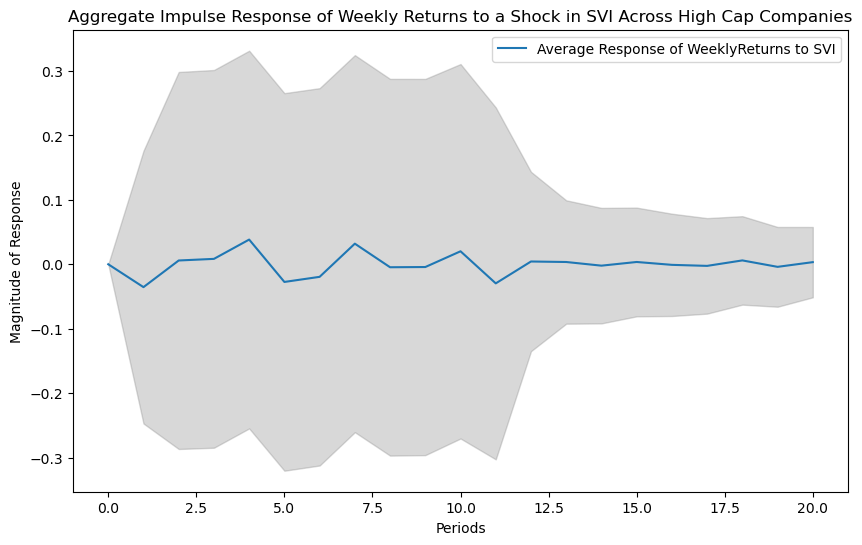

In [16]:
# Plotting the aggregate IRF
plt.figure(figsize=(10, 6))
plt.plot(avg_response, label='Average Response of WeeklyReturns to SVI')

# Plotting the confidence interval
plt.fill_between(np.arange(num_periods),
                 avg_response - 1.96 * avg_stderr,
                 avg_response + 1.96 * avg_stderr,
                 color='grey', alpha=0.3)

plt.xlabel('Periods')
plt.ylabel('Magnitude of Response')
plt.title('Aggregate Impulse Response of Weekly Returns to a Shock in SVI Across High Cap Companies')
plt.legend()
plt.show()

In [17]:
results_low = {}  # To store results for each symbol
corr_matrix_low = {}
all_responses = []
all_stderrs = []
results_low, corr_matrix_low, all_stderrs_low, all_responses_low = corr_IRF(df_low[['symbol', 'edgar', 'svi', 'volume', 'WeeklyReturns']], low_symbols, results_low, corr_matrix_low, all_stderrs,all_responses)
avg_response = np.mean(all_responses_low, axis=0)
avg_stderr = np.mean(all_stderrs_low, axis=0)
num_periods = avg_response.shape[0]



c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

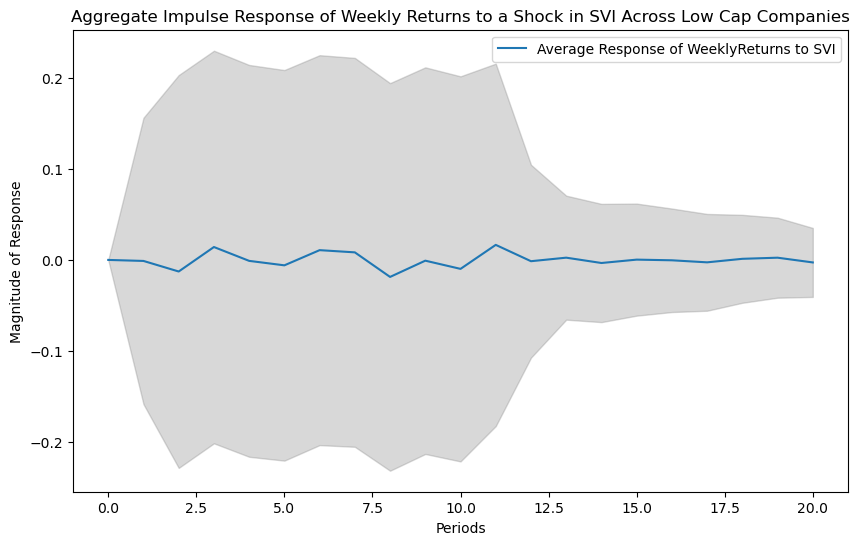

In [18]:
# Plotting the aggregate IRF
plt.figure(figsize=(10, 6))
plt.plot(avg_response, label='Average Response of WeeklyReturns to SVI')

# Plotting the confidence interval
plt.fill_between(np.arange(num_periods),
                 avg_response - 1.96 * avg_stderr,
                 avg_response + 1.96 * avg_stderr,
                 color='grey', alpha=0.3)

plt.xlabel('Periods')
plt.ylabel('Magnitude of Response')
plt.title('Aggregate Impulse Response of Weekly Returns to a Shock in SVI Across Low Cap Companies')
plt.legend()
plt.show()

In [19]:
def aic(df, symbols, aic_scores):
    
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol]
        symbol_df=symbol_df.drop(['symbol'], axis=1)
        # Ensure the DataFrame is ordered by date and drop any missing values
        symbol_df = symbol_df.dropna()

        if symbol_df.empty:
            print(f"DataFrame for {symbol} is empty after dropping NA. Skipping...")
            continue

        
        #scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = StandardScaler()
        #scaler.fit(ds[con])
        symbol_df[con] = scaler.fit_transform(symbol_df[con])
        #ds[con] = scaler.transform(ds[con])
        
        symbol_df_differenced = symbol_df.diff().dropna()
        
        # Create a VAR model
        model = VAR(symbol_df_differenced)
        for i in range(1, 21):  # Assuming you want to test lag orders from 1 to 9
            result = model.fit(i)
            aic_scores = aic_scores.append({'symbol': symbol, 'lag_order': i, 'AIC': result.aic}, ignore_index=True)
                    
    return (aic_scores)

In [20]:
aic_scores = pd.DataFrame(columns=['symbol', 'lag_order', 'AIC'])
aic_scores = aic(df_high[['symbol', 'edgar', 'svi', 'volume', 'WeeklyReturns']], high_symbols, aic_scores)


c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\baner\AppData\Local\Temp\ipykernel_6264\3297965578.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aic_scores = aic_scores.append({'symbol': symbol, 'lag_order': i, 'AIC': result.aic}, ignore_index=True)
C:\Users\baner\AppData\Local\Temp\ipykernel_6264\3297965578.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aic_scores = aic_scores.append({'symbol': symbol, 'lag_order': i, 'AIC': result.aic}, ignore_index=True)
C:\Users\baner\AppData\Local\Temp\ipykernel_6264\3297965578.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

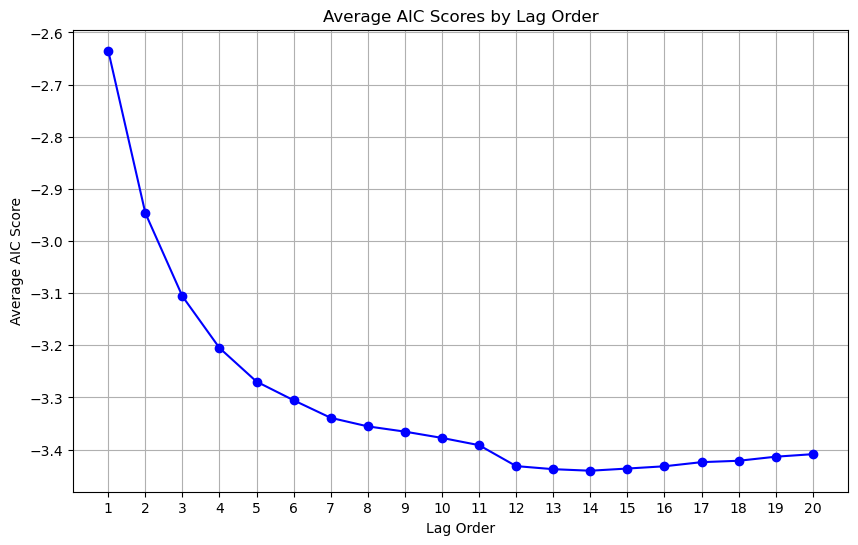

In [21]:
average_aic_scores = aic_scores.groupby('lag_order')['AIC'].mean().reset_index()
# Plotting the average AIC scores for each lag
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(average_aic_scores['lag_order'], average_aic_scores['AIC'], marker='o', linestyle='-', color='b')

plt.title('Average AIC Scores by Lag Order')  # Adding a title
plt.xlabel('Lag Order')  # X-axis label
plt.ylabel('Average AIC Score')  # Y-axis label
plt.xticks(average_aic_scores['lag_order'])  # Ensuring there's a tick for every lag order
plt.grid(True)  # Adding a grid for better readability
plt.show()  # Displaying the plot

In [24]:
# Calculate average correlation matrix
high_average_correlation = np.mean(list(corr_matrix_high.values()), axis=0)
low_average_correlation = np.mean(list(corr_matrix_low.values()), axis=0)

# Calculate variability (standard deviation) in correlations
high_variability_correlation = np.std(list(corr_matrix_high.values()), axis=0)
low_variability_correlation = np.std(list(corr_matrix_low.values()), axis=0)

In [25]:
#'edgar', 'svi', 'volume', 'WeeklyReturns'
high_average_correlation

array([[ 1.        , -0.00562953, -0.01671441, -0.00266103],
       [-0.00562953,  1.        ,  0.15154123,  0.00561416],
       [-0.01671441,  0.15154123,  1.        , -0.08340713],
       [-0.00266103,  0.00561416, -0.08340713,  1.        ]])

In [26]:
low_average_correlation

array([[ 1.00000000e+00, -5.26028230e-03,  3.68845967e-04,
        -1.62117478e-03],
       [-5.26028230e-03,  1.00000000e+00,  7.90680167e-02,
        -4.90412107e-04],
       [ 3.68845967e-04,  7.90680167e-02,  1.00000000e+00,
        -2.23345072e-02],
       [-1.62117478e-03, -4.90412107e-04, -2.23345072e-02,
         1.00000000e+00]])

In [27]:
high_variability_correlation

array([[0.        , 0.03197763, 0.03307715, 0.02784807],
       [0.03197763, 0.        , 0.18432283, 0.04513778],
       [0.03307715, 0.18432283, 0.        , 0.08525766],
       [0.02784807, 0.04513778, 0.08525766, 0.        ]])

In [28]:
low_variability_correlation

array([[0.        , 0.03108196, 0.03330402, 0.02641414],
       [0.03108196, 0.        , 0.11635193, 0.03652075],
       [0.03330402, 0.11635193, 0.        , 0.12088446],
       [0.02641414, 0.03652075, 0.12088446, 0.        ]])

In [61]:
def dendo(corr_matrix):
    # Prepare data for cluster analysis
    flattened_correlations = np.array([mat.values.flatten() for mat in corr_matrix.values()])
    linked = linkage(flattened_correlations, 'single')
    # Plot the dendrogram for cluster analysis
    plt.figure(figsize=(100, 70))
    dendrogram(linked, labels=list(corr_matrix.keys()), distance_sort='descending', show_leaf_counts=True)
    plt.title('Cluster Analysis of Companies Based on Correlation Matrices')
    plt.xlabel('Company')
    plt.ylabel('Distance')
    plt.show()
    

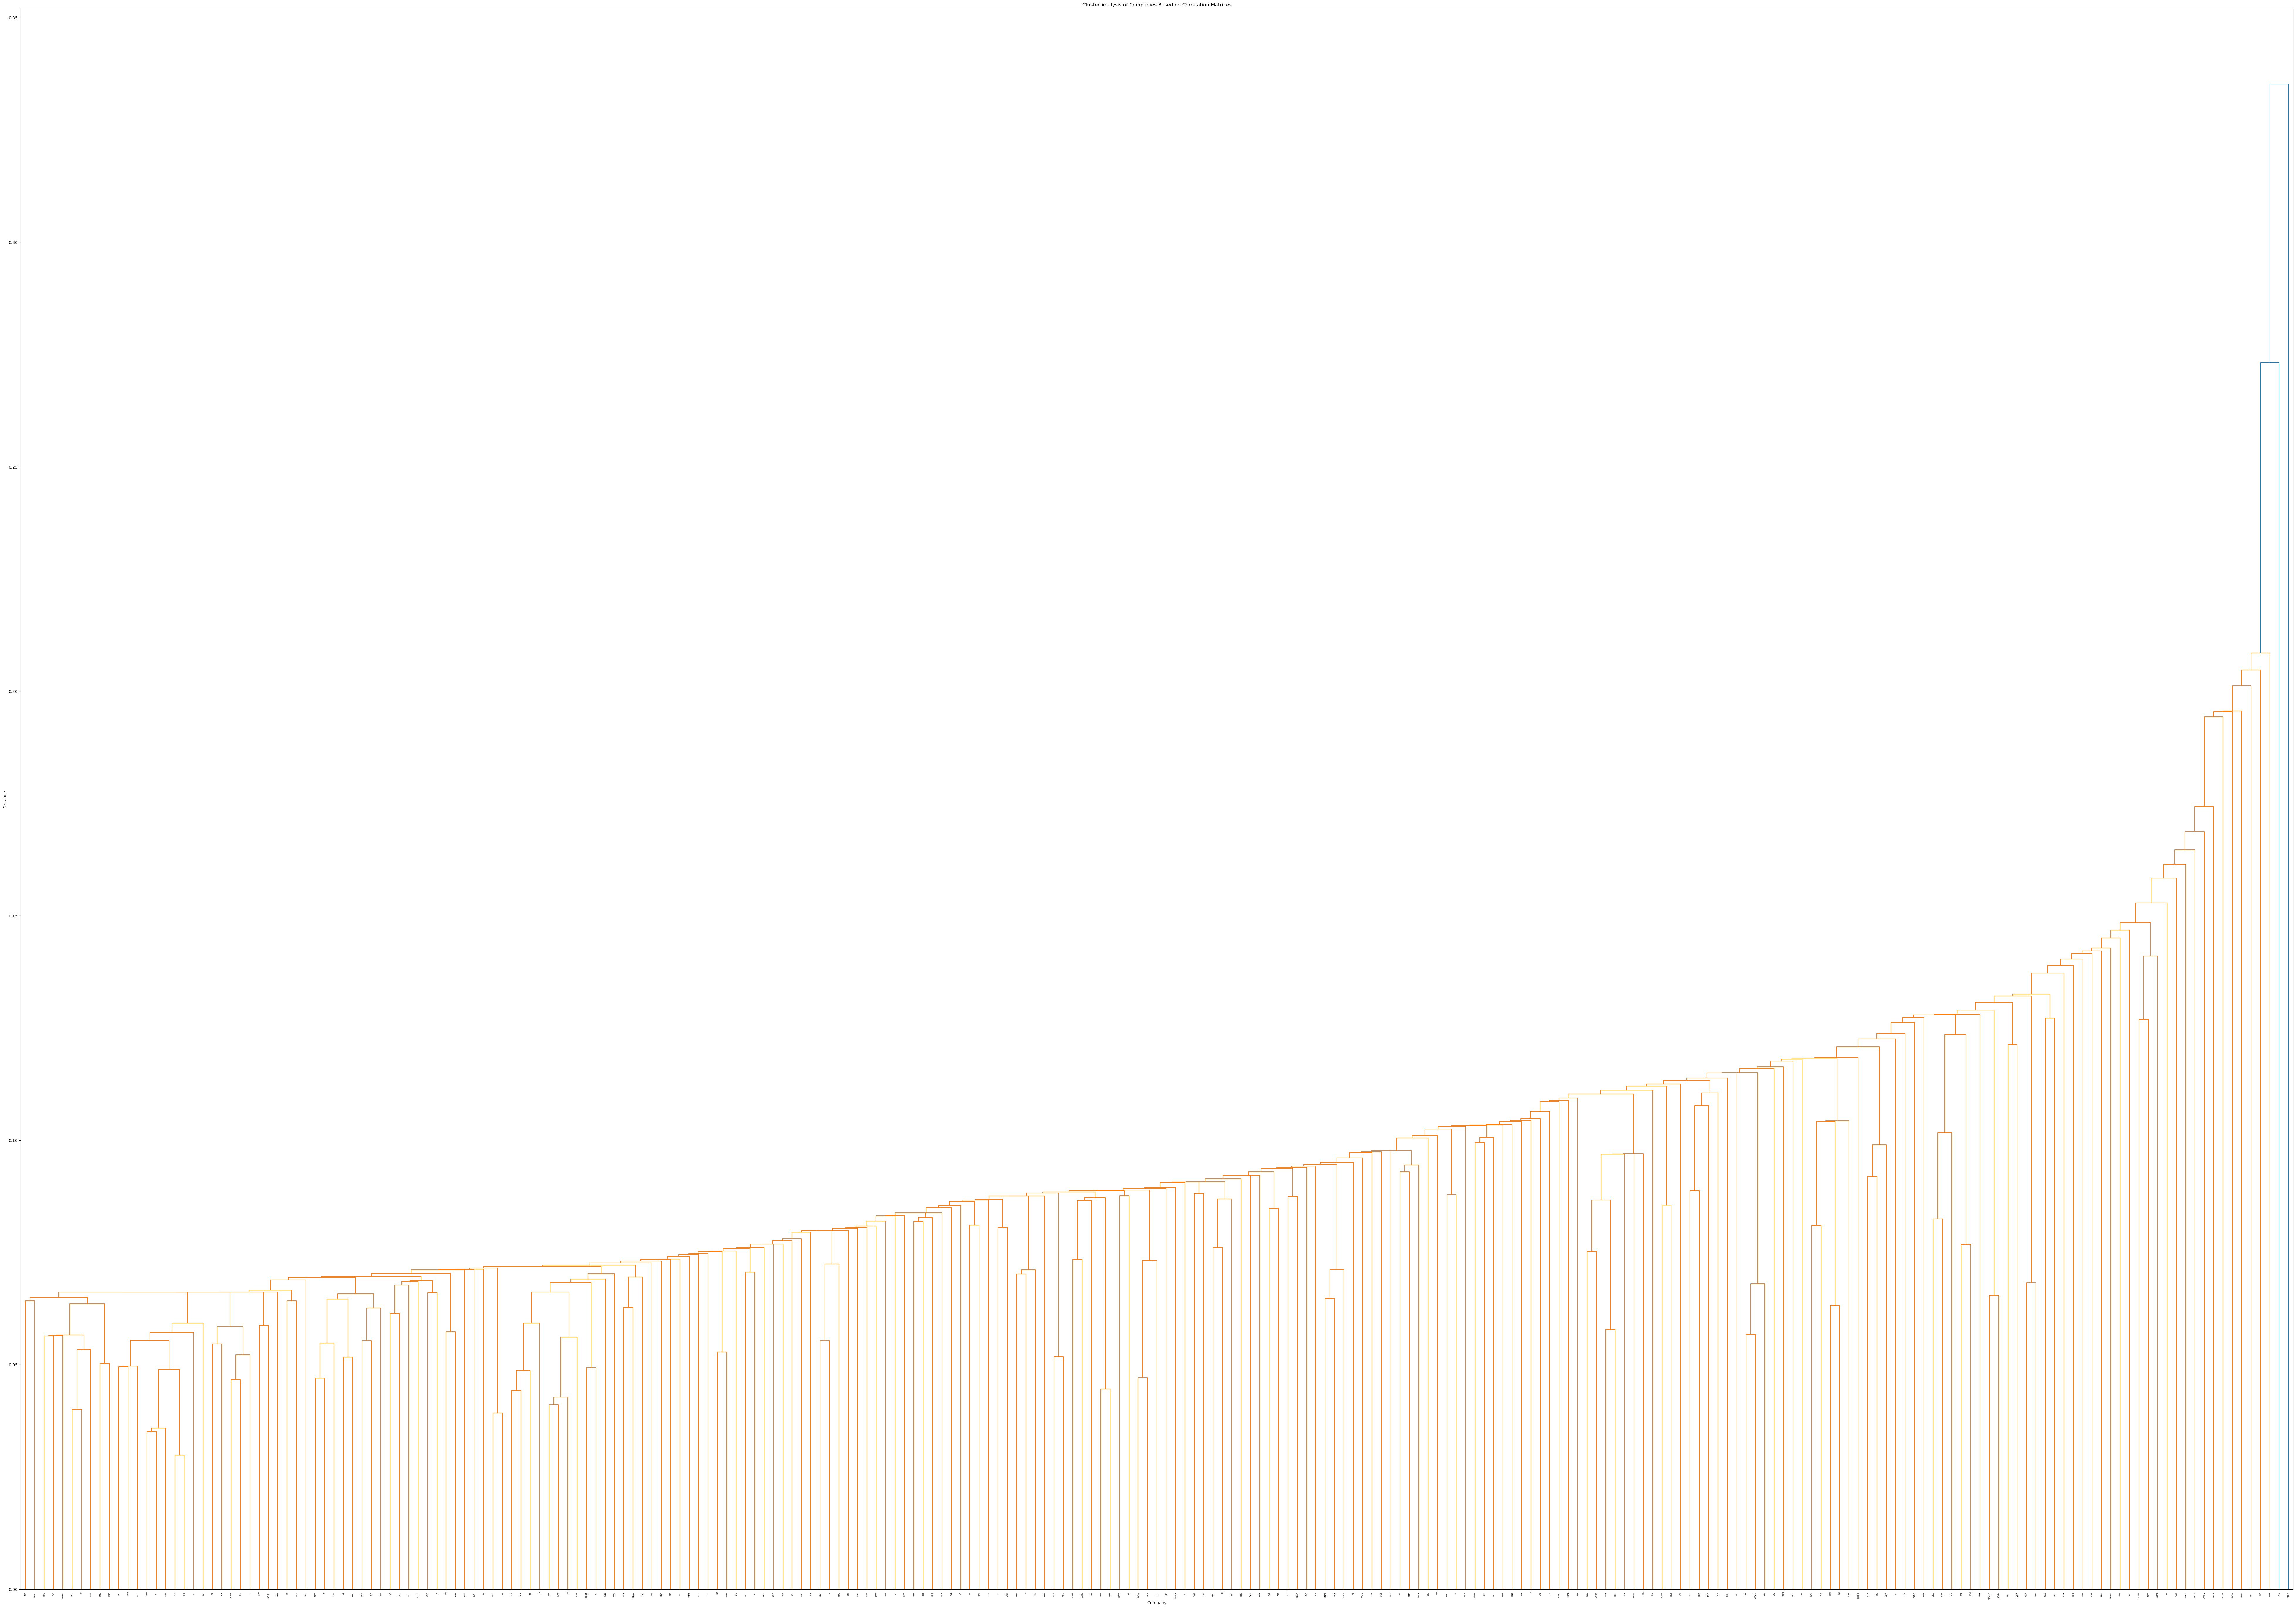

In [62]:
dendo(corr_matrix_high)

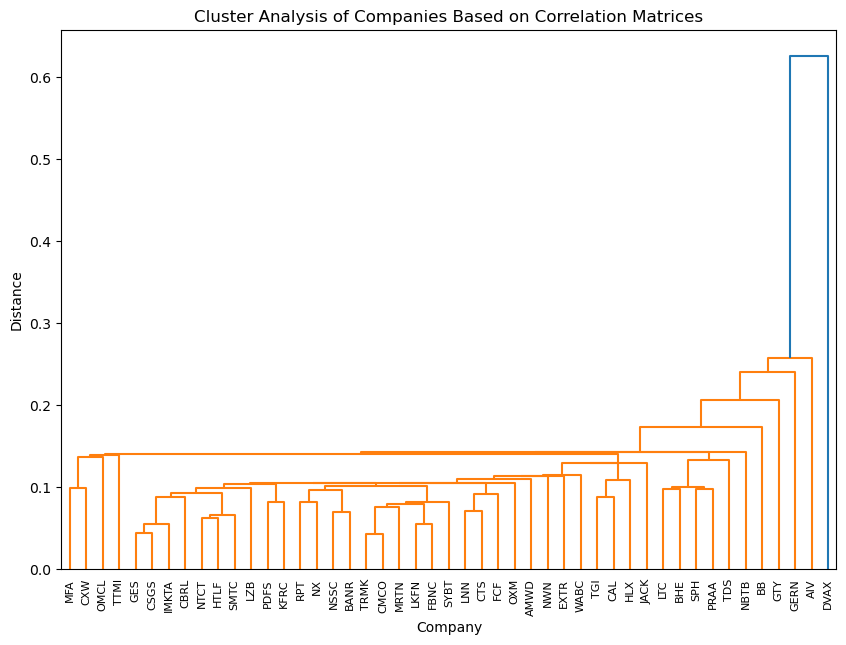

In [59]:
dendo(corr_matrix_low)

In [98]:
def edgar_volume(df, symbols, results, corr_matrix, all_stderrs, all_responses):
    
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol]
        symbol_df=symbol_df.drop(['symbol'], axis=1)
        # Ensure the DataFrame is ordered by date and drop any missing values
        symbol_df = symbol_df.dropna()

        if symbol_df.empty:
            print(f"DataFrame for {symbol} is empty after dropping NA. Skipping...")
            continue

        
        #scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = StandardScaler()
        #scaler.fit(ds[con])
        symbol_df[con] = scaler.fit_transform(symbol_df[con])
        #ds[con] = scaler.transform(ds[con])
        
        symbol_df_differenced = symbol_df.diff().dropna()
        
        # Create a VAR model
        model = VAR(symbol_df_differenced)
        result = model.fit(10)
        irf = result.irf(20)  
        response_to_svi = irf.irfs[:, result.names.index('svi'), result.names.index('WeeklyReturns')]
        stderr_to_edgar = irf.stderr()[0:21, result.names.index('svi'), result.names.index('WeeklyReturns')]

        all_responses.append(response_to_svi)
        all_stderrs.append(stderr_to_edgar)
        
        # Fit the model with an appropriate lag order
        # Here, we use automatic lag order selection based on AIC
        # You might want to adjust this based on your specific dataset
        
        result = model.fit(5)
        
        residuals = result.resid

        # Convert residuals to a DataFrame (if they are not already in this format)
        residuals_df = pd.DataFrame(residuals)

        # Calculate the correlation matrix of residuals
        corr_matrix[symbol] = residuals_df.corr()    
        # Store the result object for further analysis
        results[symbol] = result
            # Print summary for each symbol (optional)
        #print(f"VAR model for {symbol}")
        #result.summary()
    return (results, corr_matrix, all_stderrs, all_responses)

In [99]:
results_high = {}  # To store results for each symbol
corr_matrix_high = {}
all_responses = []
all_stderrs = []
results_high, corr_matrix_high, all_stderrs_high, all_responses_high = svi_volume(df_high[['symbol', 'edgar', 'svi', 'volume', 'WeeklyReturns']], high_symbols, results_high, corr_matrix_high, all_stderrs,all_responses)
avg_response = np.mean(all_responses_high, axis=0)
avg_stderr = np.mean(all_stderrs_high, axis=0)
num_periods = avg_response.shape[0]

c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\baner\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

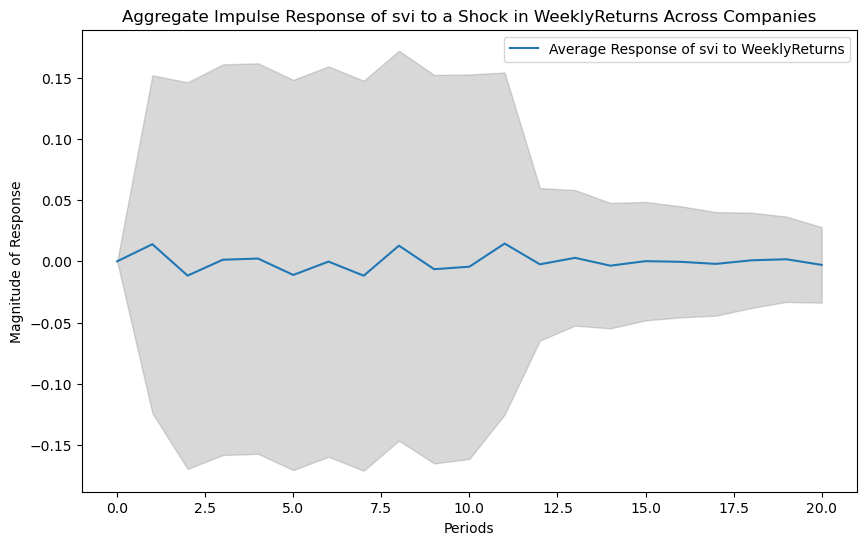

In [100]:
# Plotting the aggregate IRF
plt.figure(figsize=(10, 6))
plt.plot(avg_response, label='Average Response of svi to WeeklyReturns')

# Plotting the confidence interval
plt.fill_between(np.arange(num_periods),
                 avg_response - 1.96 * avg_stderr,
                 avg_response + 1.96 * avg_stderr,
                 color='grey', alpha=0.3)

plt.xlabel('Periods')
plt.ylabel('Magnitude of Response')
plt.title('Aggregate Impulse Response of svi to a Shock in WeeklyReturns Across Companies')
plt.legend()
plt.show()